<a href="https://colab.research.google.com/github/varnikanalla/vptv/blob/main/Copy_of_no_of_objects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless matplotlib tensorflow

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import os


In [ ]:
print("Please upload an image...")
uploaded = files.upload()

for filename in uploaded.keys():
    image_path = '/content/' + filename


Please upload an image...


In [ ]:
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

kernel = np.ones((5, 5), np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [ ]:
def train_mnist_model():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))
    model.save("digit_classifier.h5")
    return model

if os.path.exists("digit_classifier.h5"):
    model = load_model("digit_classifier.h5")
else:
    model = train_mnist_model()


In [ ]:
annotated = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

for i, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)
    roi = thresh[y:y+h, x:x+w]

    try:
        roi_resized = cv2.resize(roi, (28, 28))
        roi_resized = roi_resized.astype('float32') / 255.0
        roi_input = roi_resized.reshape(1, 28, 28, 1)

        prediction = model.predict(roi_input)
        label = np.argmax(prediction)

        # Draw box and label
        cv2.rectangle(annotated, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(annotated, str(label), (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    except:
        pass  # Skip small/invalid contours


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


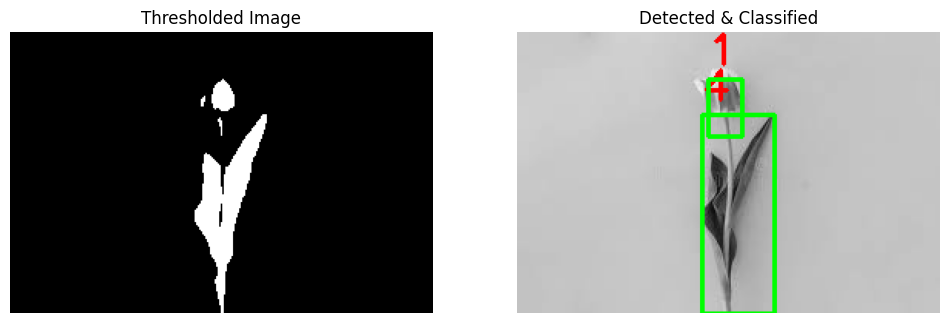

Number of objects detected: 2


In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Thresholded Image")
plt.imshow(thresh, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Detected & Classified")
plt.imshow(annotated)
plt.axis('off')

plt.show()

print("Number of objects detected:", len(contours))
